# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# load weekly sales dataset

filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

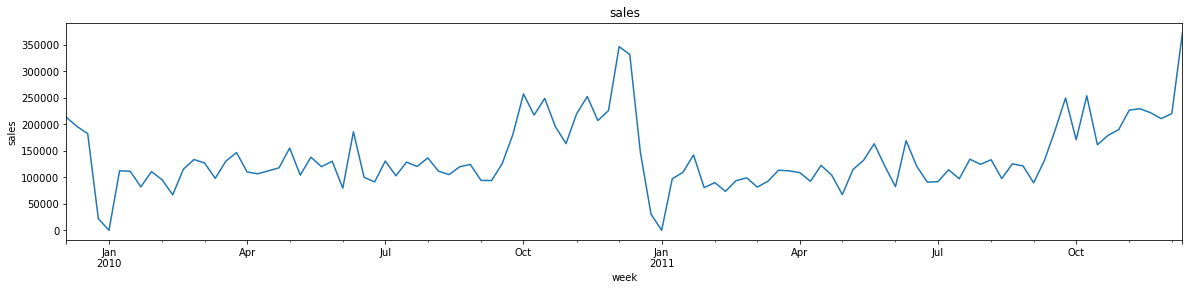

In [3]:
for var in ["sales"]:

    # Plot the time series
    df[var].plot(figsize=(20, 4))

    # Add title
    plt.title(var)

    # the y axis label
    plt.ylabel(var)

    plt.show()

## Missing data

Check if there are missing values in the time series.

In [4]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

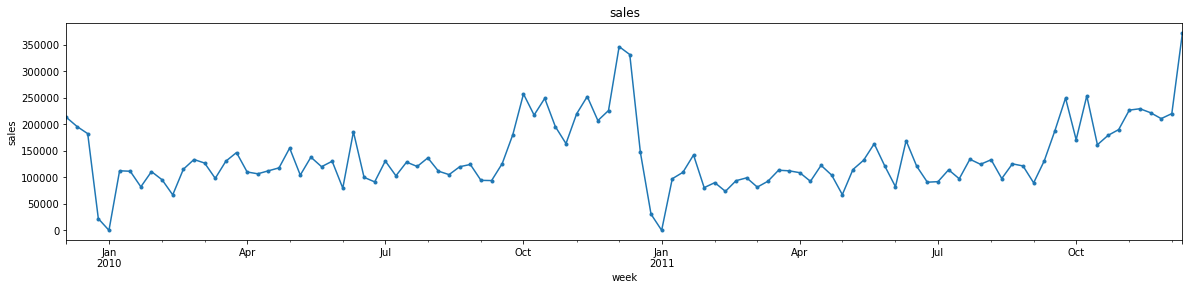

In [5]:
df_ = df.asfreq("1W")

# Apply the forward fill method.
df_imputed = df_.fillna(method="ffill")

# Plot the imputed time series.
for var in ["sales"]:

    # plot the time series.
    ax = df_[var].plot(linestyle="-", marker=".", figsize=[20, 4])

    # plot the imputed values on top, in red.
    df_imputed[df_.isnull()][var].plot(ax=ax, legend=None, marker=".", color="r")

    # Add title.
    plt.title(var)

    # the y axis label
    plt.ylabel(var)

    plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

In [6]:
time_ = df.index

time_ = pd.Series(time_, index=df.index)

time_.head()

week
2009-12-06   2009-12-06
2009-12-13   2009-12-13
2009-12-20   2009-12-20
2009-12-27   2009-12-27
2010-01-03   2010-01-03
Name: week, dtype: datetime64[ns]

In [7]:
df.index

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='week', length=106, freq=None)

Text(0, 0.5, 'Sales')

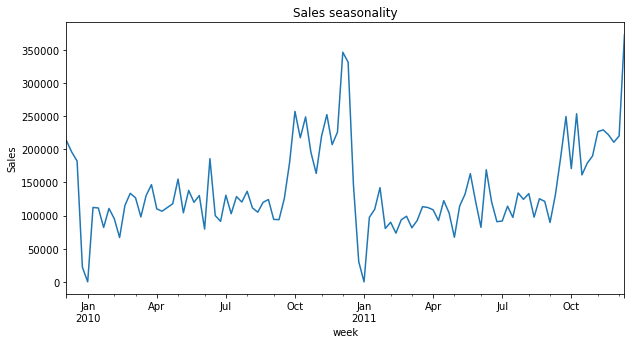

In [8]:
df.groupby(time_)["sales"].mean().plot(figsize=(10, 5))
plt.title("Sales seasonality")
plt.ylabel("Sales")

# Feature engineering

Now, let's begin to tabularize the data.

In [9]:
df

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
...,...
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76


In [10]:
# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr.
tmp = df[variables].shift(freq="1W")

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 1)
data size after
(106, 2)


,sales,sales_lag_1
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,213000.35
2009-12-20,182396.74,195810.04
2009-12-27,22007.77,182396.74
2010-01-03,0.00,22007.77


In [11]:
df[["sales", "sales_lag_1"]].head()

,sales,sales_lag_1
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,213000.35
2009-12-20,182396.74,195810.04
2009-12-27,22007.77,182396.74
2010-01-03,0.00,22007.77


In [12]:
df.isnull().sum()

sales          0
sales_lag_1    1
dtype: int64

In [19]:
print("data size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

data size before
(106, 2)
data size after
(105, 2)


In [ ]:
# df["Month"] = df.index.month
# df["Week"] = df.index.isocalendar().week

In [ ]:
# df.loc[df["Month"]== 9]

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [20]:
df.index.min(), df.index.max()

(Timestamp('2009-12-13 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [21]:
X_train = df[df.index <= "2011-09-25"]
X_test = df[df.index > "2011-09-25"]

X_train.shape, X_test.shape

((94, 2), (11, 2))

In [22]:
df

,sales,sales_lag_1
week,,
2009-12-13,195810.04,213000.35
2009-12-20,182396.74,195810.04
2009-12-27,22007.77,182396.74
2010-01-03,0.00,22007.77
2010-01-10,112318.85,0.00
...,...,...
2011-11-13,229378.01,226770.53
2011-11-20,221870.29,229378.01
2011-11-27,210741.76,221870.29


In [23]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [24]:
print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  48097.28537936963
test rmse:  65327.34284108448


## Machine Learning

In [26]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  43912.111121039314
test rmse:  71354.30920333264


Text(0, 0.5, 'Importance')

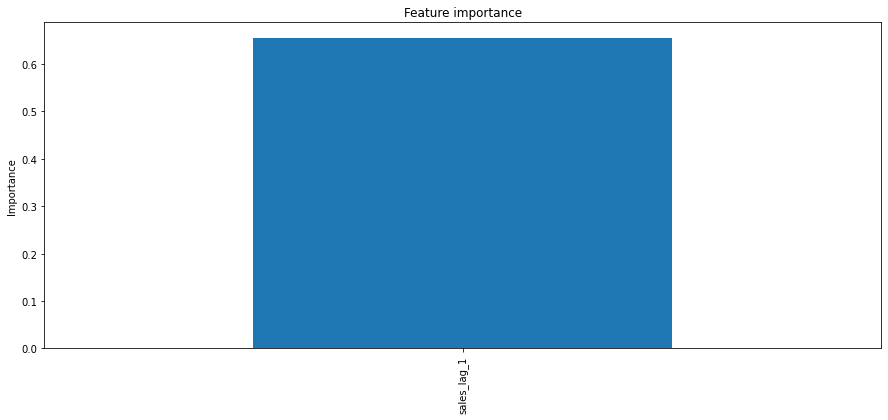

In [27]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")